In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from torch.distributions import *
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io



class imgDataset(Dataset):
    def __init__(self, transform=None):
        self.img_list = os.listdir('img/')
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        name= self.img_list[idx]
        
        img_name = 'img/'+ name
        
        img = io.imread(img_name)
        img = img[0:180,70:250,:]
        sample = img
        if self.transform:
            sample = self.transform(sample)
        return sample


dataset = imgDataset(transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset,batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
class Encoder(nn.Module):
  def __init__(self,z=10):
    super(Encoder, self).__init__()

    # self.l1 = nn.Linear(28*28,256)
    self.conv1 = nn.Conv2d(3,8,(7,7),stride=4)
    self.conv2 = nn.Conv2d(8,16,(5,5),stride=3)
    self.conv3 = nn.Conv2d(16,32,(3,3),stride=2)

    
    self.fc = nn.Linear(32*6*6,128)    
 
    self.mean = nn.Linear(128 ,32)
    self.log_std = nn.Linear(128 ,32)

  def forward(self, img):
    # print('img',img.shape)
    out = F.leaky_relu(self.conv1(img))
    # print('out1',out.shape)

    out = F.leaky_relu(self.conv2(out))
    # print('out2',out.shape)

    out = F.leaky_relu(self.conv3(out))
    # print('out3',out.shape)

    out = out.reshape(-1,32*6*6)
    out = F.leaky_relu(self.fc(out))
    mean = 	F.tanh(self.mean(out))
    log_std = self.log_std(out)
    return mean,log_std


class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.fc1 = nn.Linear(32,128)
    self.fc2 = nn.Linear(128,32*6*6)
    self.conv1 = nn.Conv2d(32,16,(3,3),padding='same')
    self.conv2 = nn.Conv2d(16,8,(5,5),padding='same')
    self.conv3 = nn.Conv2d(8,3,(7,7),padding='same')
  def forward(self, lat):
    # print(lat.shape)
    out = F.leaky_relu(self.fc1(lat))
    out = F.leaky_relu(self.fc2(out))
    out = out.reshape(-1,32,6,6)
    out = F.leaky_relu(self.conv1(F.interpolate(out,(14,14),mode='bilinear')))
    out = F.leaky_relu(self.conv2(F.interpolate(out,(44,44),mode='bilinear')))
    out = F.sigmoid(self.conv3(F.interpolate(out,(180,180),mode='bilinear')))

    return	out



In [8]:
class autoencoder(object):
  def __init__(self):
    self.decoder = Decoder().to(device)
    self.encoder = Encoder().to(device)
    self.optimizer =  torch.optim.Adam(list(self.encoder.parameters())+list(self.decoder.parameters()),lr=1e-3)



  def train(self,data_loader):
    img = next(iter(data_loader))
    img = img.to(device)
    beta = 5

    mean,log_std = self.encoder(img)

    var = torch.exp(2*log_std)
 
    a = torch.arange(0,var.shape[1]).to(device)
    cov_mat = torch.zeros((var.shape[0],var.shape[1],var.shape[1])).to(device)
    cov_mat[:,a,a] = var

    nor_dist = torch.distributions.MultivariateNormal(mean, cov_mat)

    standard_nor = torch.distributions.MultivariateNormal(torch.zeros(mean.shape[1]).to(device), torch.eye(cov_mat.shape[1]).to(device))

    latent = standard_nor.sample((mean.shape[0],))*torch.exp(log_std) + mean

    bern = self.decoder(latent)
    
    loss =  nn.BCELoss(reduction='sum')(bern,img)/torch.tensor(64) + beta*kl_divergence(nor_dist,standard_nor).mean(0)
    self.optimizer.zero_grad()


    loss.backward()

    self.optimizer.step()
    
    return loss



In [10]:
auto = autoencoder()
loss = 0

for i in range(1001):
  loss+= auto.train(train_loader)
  if (i+1)%100==0:
    print(i,loss/100)
    loss = 0

99 tensor(41236.9258, device='cuda:0', grad_fn=<DivBackward0>)
199 tensor(32894.1133, device='cuda:0', grad_fn=<DivBackward0>)
299 tensor(30889.5137, device='cuda:0', grad_fn=<DivBackward0>)
399 tensor(30310.4512, device='cuda:0', grad_fn=<DivBackward0>)
499 tensor(29896.1699, device='cuda:0', grad_fn=<DivBackward0>)
599 tensor(29786.8438, device='cuda:0', grad_fn=<DivBackward0>)
699 tensor(29591.6719, device='cuda:0', grad_fn=<DivBackward0>)
799 tensor(29427.2246, device='cuda:0', grad_fn=<DivBackward0>)
899 tensor(29381.5488, device='cuda:0', grad_fn=<DivBackward0>)
999 tensor(29317.9160, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
for i in range(10001):
  loss+= auto.train(train_loader)
  if (i+1)%100==0:
    print(i,loss/100)
    loss = 0

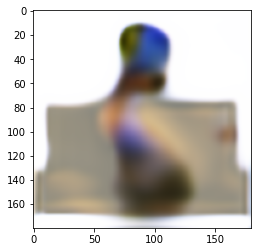

In [66]:
# i = 901


# f, axarr = plt.subplots(1,2)

# genr = auto.decoder(auto.encoder(dataset2[i][0].to(device)))
# img = dataset2[i][0]
# bin_img = (img>0.5).float()

# plt.imshow(bin_img.detach().cpu().squeeze(),cmap='gray')
standard_nor = torch.distributions.MultivariateNormal(torch.zeros(32,).to(device), torch.eye(32,).to(device))

latent = standard_nor.sample()

bern = auto.decoder(latent)



# generated_smooth = bern.reshape(-1,3,180,180)
plt.imshow(bern.detach().cpu().squeeze().numpy().transpose(1,2,0))
# plt.imshow(bern.detach().cpu().squeeze())
# axarr[0].imshow(generated_smooth.detach().cpu().squeeze(),cmap='gray')

In [ ]:
standard_nor = torch.distributions.MultivariateNormal(torch.zeros(32,), torch.eye(32,))

latent = standard_nor.sample()
print(latent.shape)
print(auto.decoder)
bern = auto.decoder(latent.unsqueeze(0))



# io.imsave('a',bern)

NameError: name 'torch' is not defined

In [ ]:
img = next(iter(data_loader))
img = img.to(device)
beta = 5

mean,log_std = auto.encoder(img)

var = torch.exp(2*log_std)

a = torch.arange(0,var.shape[1]).to(device)
cov_mat = torch.zeros((var.shape[0],var.shape[1],var.shape[1])).to(device)
cov_mat[:,a,a] = var

nor_dist = torch.distributions.MultivariateNormal(mean, cov_mat)

standard_nor = torch.distributions.MultivariateNormal(torch.zeros(mean.shape[1]).to(device), torch.eye(cov_mat.shape[1]).to(device))

latent = standard_nor.sample((mean.shape[0],))*torch.exp(log_std) + mean

bern = auto.decoder(latent)

NameError: name 'data_loader' is not defined